In [1]:
import numpy as np
import pandas as pd
import os
import time
import copy
import neptune
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data as data_utils
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# For image-keypoints data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tensorflow.python.client import device_lib
import tensorflow as tf

device_lib.list_local_devices()

tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None)
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[]

In [2]:
# Prefix data directory
prefix_dir = 'E:/'

# Top level data directory. Here we assume the format of the directory conforms
# to the ImageFolder structure
train_dir = 'E:/data/train_imgs'

# Models to choose from torchvision
model_name = 'resnet'
model_ver = '18'

# Number of classes in the dataset
num_classes = 48

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs and earlystop to train for
num_epochs = 50

num_splits = 5
num_earlystop = 10

# Iput size for resize imgae
input_w = 150
input_h = 150

# Learning rate for optimizer
learning_rate = 0.01

# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
feature_extract = False

In [3]:
df = pd.read_csv('E:/data/train_df.csv')
df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,...,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,...,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,...,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,...,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,...,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102


In [4]:
imgs = df.iloc[:, 0].to_numpy()
motions = df.iloc[:, 1:]
columns = motions.columns.to_list()[::2]
class_labels = [label.replace('_x', '').replace('_y', '') for label in columns]
keypoints = []
for motion in motions.to_numpy():
    a_keypoints = []
    for i in range(0, motion.shape[0], 2):
        a_keypoints.append((float(motion[i]), float(motion[i+1])))
    keypoints.append(a_keypoints)
keypoints = np.array(keypoints)

In [5]:
def train_model(model, dataloaders, criterion, optimizer, earlystop=0, num_epochs=32, is_inception=False):
    since = time.time()
    
    val_acc_history = []
    val_loss_history = []
    earlystop_value = 0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 999999999
    
    for epoch in range(num_epochs):
        epoch_since = time.time()
        if earlystop and earlystop_value >= earlystop:
            break

        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs.float(), labels.float())
                        loss2 = criterion(aux_outputs.float(), labels.float())
                        loss = loss1 + 0.4*loss2
                        loss.backward()
                        optimizer.step()
                        
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs.float(), labels.float())

                    # backward + optimize only if in training phase
                    # if phase == 'train':
                    #     loss.backward()
                    #     optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # for regression
                running_corrects += torch.sum(outputs == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            epoch_time_elapsed = time.time() - epoch_since
            print('{} ({}) Loss: {:.4f} Acc: {:.4f} Elapsed time: {:.0f}m {:.0f}s'.format(
                phase, len(dataloaders[phase].dataset), epoch_loss, epoch_acc, epoch_time_elapsed // 60, epoch_time_elapsed % 60))
            # neptune.log_metric(f'{phase}_loss', epoch_loss)
            # neptune.log_metric(f'{phase}_acc', epoch_acc)
            
            # deep copy the model
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    earlystop_value = 0
                else:
                    earlystop_value += 1
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training and Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best validation Acc: {:4f}\n'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, {'acc': val_acc_history, 'loss': val_loss_history}

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
def initialize_model(model_name, model_ver, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    model_ft = getattr(models, f'{model_name}{model_ver}')(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    return model_ft

# Initialize the model for this run
model_ft = initialize_model(model_name, model_ver, num_classes, feature_extract, use_pretrained=True)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Print the model we just instantiated
# print(model_ft)
print(torch.cuda.is_available())

True


In [8]:
# Data augmentation and normalization for training with Albumentations
A_transforms = {
    'train':
        A.Compose([
            A.Resize(input_h, input_w, always_apply=True),
            # A.RandomCrop(150, 150),
            A.OneOf([A.HorizontalFlip(p=1),
                     A.RandomRotate90(p=1),
                     A.VerticalFlip(p=1)            
            ], p=0.7),
            A.OneOf([A.MotionBlur(p=1),
                     A.GaussNoise(p=1)
                                    
            ], p=0.5),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True, angle_in_degrees=True)),
    
    'val':
        A.Compose([
            A.Resize(input_h, input_w, always_apply=True),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True, angle_in_degrees=True)),
    
    'test':
        A.Compose([
            A.Resize(input_h, input_w, always_apply=True),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
}

In [9]:
class Dataset(data_utils.Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, keypoints, phase, class_labels=None, data_transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.keypoints = keypoints
        self.phase = phase
        self.class_labels = class_labels
        self.data_transforms = data_transforms

    def __getitem__(self, idx):
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))
        keypoints = self.keypoints[idx]
    
        if self.data_transforms:
            augmented = self.data_transforms[self.phase](image=img, keypoints=keypoints, class_labels=self.class_labels)
            img = augmented['image']
            keypoints = augmented['keypoints']
        keypoints = np.array(keypoints).flatten()

        return img, keypoints
    
    def __len__(self):
        return len(self.imgs)

In [10]:
# Setup the loss fxn
criterion = nn.MSELoss()

since = time.time()
X_train, X_val, y_train, y_val = train_test_split(imgs, keypoints, test_size=0.15, random_state=42)
train_data = Dataset(train_dir, X_train, y_train, data_transforms=A_transforms, class_labels=class_labels, phase='train')
val_data = Dataset(train_dir, X_val, y_val, data_transforms=A_transforms, class_labels=class_labels, phase='val')
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = data_utils.DataLoader(val_data, batch_size=batch_size, shuffle=True)
dataloaders = {'train': train_loader, 'val': val_loader}
# print(len(X_train), len(X_val))
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

# Train and evaluate
model_ft, hists = train_model(model_ft, dataloaders, criterion, optimizer_ft,
    num_epochs=num_epochs, earlystop=num_earlystop, is_inception=(model_name=="inception"))
torch.save(model_ft.state_dict(), f'{prefix_dir}/data/{model_name}{model_ver}.pt')
time_elapsed = time.time() - since
print('Elapsed time: {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/50
----------
train (3565) Loss: 6048.2765 Acc: 0.0000 Elapsed time: 2m 5s
val (630) Loss: 6332.6129 Acc: 0.0000 Elapsed time: 2m 25s

Epoch 2/50
----------
train (3565) Loss: 6053.2163 Acc: 0.0000 Elapsed time: 1m 16s
val (630) Loss: 6331.7142 Acc: 0.0000 Elapsed time: 1m 28s

Epoch 3/50
----------
train (3565) Loss: 6023.8357 Acc: 0.0000 Elapsed time: 1m 15s
val (630) Loss: 6333.6348 Acc: 0.0000 Elapsed time: 1m 27s

Epoch 4/50
----------
train (3565) Loss: 6026.6126 Acc: 0.0000 Elapsed time: 1m 15s
val (630) Loss: 6332.1496 Acc: 0.0000 Elapsed time: 1m 27s

Epoch 5/50
----------
train (3565) Loss: 6034.5993 Acc: 0.0000 Elapsed time: 1m 14s
val (630) Loss: 6333.4744 Acc: 0.0000 Elapsed time: 1m 27s

Epoch 6/50
----------
train (3565) Loss: 6039.1356 Acc: 0.0000 Elapsed time: 1m 15s
val (630) Loss: 6332.7618 Acc: 0.0000 Elapsed time: 1m 28s

Epoch 7/50
----------
train (3565) Loss: 6062.1163 Acc: 0.0000 Elapsed time: 1m 15s
val (630) Loss: 6332.4670 Acc: 0.0000 Elapsed time: 1

In [11]:
model_ft.load_state_dict(torch.load(f'{prefix_dir}data/{model_name}{model_ver}.pt'))

<All keys matched successfully>

In [12]:
test_dir = f'{prefix_dir}data/test_imgs'
test_imgs = os.listdir(test_dir)

In [13]:
class TestDataset(data_utils.Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, phase, data_transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.phase = phase
        self.data_transforms = data_transforms

    def __getitem__(self, idx):
        filename = self.imgs[idx]
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))

        if self.data_transforms:
            augmented = self.data_transforms[self.phase](image=img)
            img = augmented['image']
        return filename, img
    
    def __len__(self):
        return len(self.imgs)
    
test_data = TestDataset(test_dir, test_imgs, data_transforms=A_transforms, phase='test')
test_loader = data_utils.DataLoader(test_data, batch_size=batch_size * 4, shuffle=False)

In [14]:
all_predictions = []
files = []
with torch.no_grad():
    for filenames, inputs in test_loader:
        predictions = list(model_ft(inputs.to(device)).cpu().numpy())
        files.extend(filenames)
        for prediction in predictions:
            all_predictions.append(prediction)

In [15]:
all_predictions = np.array(all_predictions)
for i in range(all_predictions.shape[0]):
    all_predictions[i, [2*j for j in range(num_classes//2)]] /= input_w / 1920
    all_predictions[i, [2*j + 1 for j in range(num_classes//2)]] /= input_h / 1080

In [16]:
df_sub = pd.read_csv(f'{prefix_dir}data/sample_submission.csv')
df = pd.DataFrame(columns=df_sub.columns)
df['image'] = files
df.iloc[:, 1:] = all_predictions
# df.set_index('image', inplace=True)
df.tail(10)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
1590,786-3-5-41-Z94_E-0000013.jpg,-5.967341,-5.186311,8.873516,-0.811493,-0.188614,3.377793,-27.703175,-3.241126,9.461572,...,-0.59368,0.94743,-3.817278,5.972293,-1.084439,-2.348654,30.881016,-4.235079,4.770017,6.635884
1591,786-3-5-41-Z94_E-0000015.jpg,-8.729719,-6.387141,12.162921,0.108358,-1.773322,3.357177,-27.639416,-2.56063,7.08056,...,-1.042667,0.739687,-4.263521,5.704187,-0.799215,-2.492986,28.829065,-6.720167,4.6655,6.078562
1592,786-3-5-41-Z94_E-0000017.jpg,-8.250792,-4.578729,9.913169,-1.39207,-1.440058,2.475366,-22.329288,-0.990062,5.460622,...,-1.9628,1.007131,-7.056857,6.367857,4.048562,0.340773,25.868774,-6.338541,9.798422,5.166007
1593,786-3-5-41-Z94_E-0000019.jpg,-10.450237,-4.539557,11.873981,0.950519,-1.494476,4.50024,-26.726257,-2.116135,4.884389,...,-2.698517,0.970661,-4.774463,3.956357,3.748803,-2.591287,30.52457,-5.359596,6.200299,4.649295
1594,786-3-5-41-Z94_E-0000021.jpg,-6.254098,-3.548452,11.03253,1.126237,0.062679,5.383376,-21.443485,-0.647235,6.764432,...,1.85674,2.289971,-8.667378,4.906284,2.440098,-1.079347,20.593168,-3.522535,7.286747,5.280483
1595,786-3-5-41-Z94_E-0000023.jpg,-7.894315,-5.730424,12.912285,1.247108,2.112745,3.976409,-25.874775,-2.49344,4.152576,...,-3.414145,1.479808,-2.054814,2.684781,-0.677324,-5.244478,28.335434,-5.06695,3.116184,5.226272
1596,786-3-5-41-Z94_E-0000025.jpg,-5.100299,-2.741293,12.496645,0.904282,-2.252468,4.270484,-21.296564,-0.428356,6.413756,...,-0.478949,3.649867,-5.35772,5.265153,2.197687,-2.219617,23.578039,-5.171326,5.729879,5.934851
1597,786-3-5-41-Z94_E-0000027.jpg,-10.335529,-7.387802,12.628362,1.483996,0.348766,4.451855,-26.376385,-2.388596,4.944572,...,-2.998052,1.661676,-3.995689,3.706991,4.433452,-3.584989,29.059208,-4.943664,5.177021,5.385754
1598,786-3-5-41-Z94_E-0000029.jpg,-5.071126,-3.752737,6.964199,0.138335,-1.881574,2.754254,-23.370136,-2.205972,5.640122,...,0.612961,1.852648,-2.311639,4.224769,3.032236,-2.239123,28.176706,-6.241107,3.941263,4.868098
1599,786-3-5-41-Z94_E-0000031.jpg,-4.031036,-3.421399,9.588255,0.174535,0.817894,4.269421,-22.870724,-1.270955,7.036112,...,0.959502,3.021111,-4.707133,5.054395,1.414664,-1.461185,22.141626,-4.127247,5.792743,5.494058


In [17]:
df.to_csv(f'{prefix_dir}data/{model_name}{model_ver}.csv', index=False)
df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,-24.449163,3.116155,15.524571,5.876275,-6.306597,1.331811,-3.853497,-5.961245,7.362246,...,-10.736096,2.132157,-8.755583,1.041539,7.566373,-6.848301,1.359293,-5.025831,10.60482,4.943368
1,649-2-4-32-Z148_A-0000003.jpg,-25.039677,4.150185,15.498163,5.703419,-8.050665,2.665032,-5.071471,-5.00236,8.46337,...,-9.906113,3.0724,-9.290732,1.602714,6.45666,-6.560863,1.406585,-4.98047,10.837839,4.768504
2,649-2-4-32-Z148_A-0000005.jpg,-29.739141,0.185941,22.200264,4.347219,-5.895766,2.652669,-7.561234,-7.460869,5.187259,...,-7.281304,-0.221108,-7.768608,1.800549,6.878454,-6.366083,5.289353,-4.757443,13.851898,4.245217
3,649-2-4-32-Z148_A-0000007.jpg,-22.909117,6.807351,14.633474,5.365739,-7.873332,-1.016921,-10.249223,-5.698698,10.011393,...,-8.898968,6.709099,-6.13288,-3.334451,1.894363,-5.256912,-8.508521,-2.694794,14.22315,5.041458
4,649-2-4-32-Z148_A-0000009.jpg,-25.07498,0.516285,19.590916,4.785348,-8.289721,3.515989,-5.317046,-6.385546,7.762074,...,-4.819743,-1.36474,-6.656779,0.177657,4.121229,-3.197901,5.539778,-3.318265,12.205485,3.884799


In [18]:
aa = df.set_index('image')

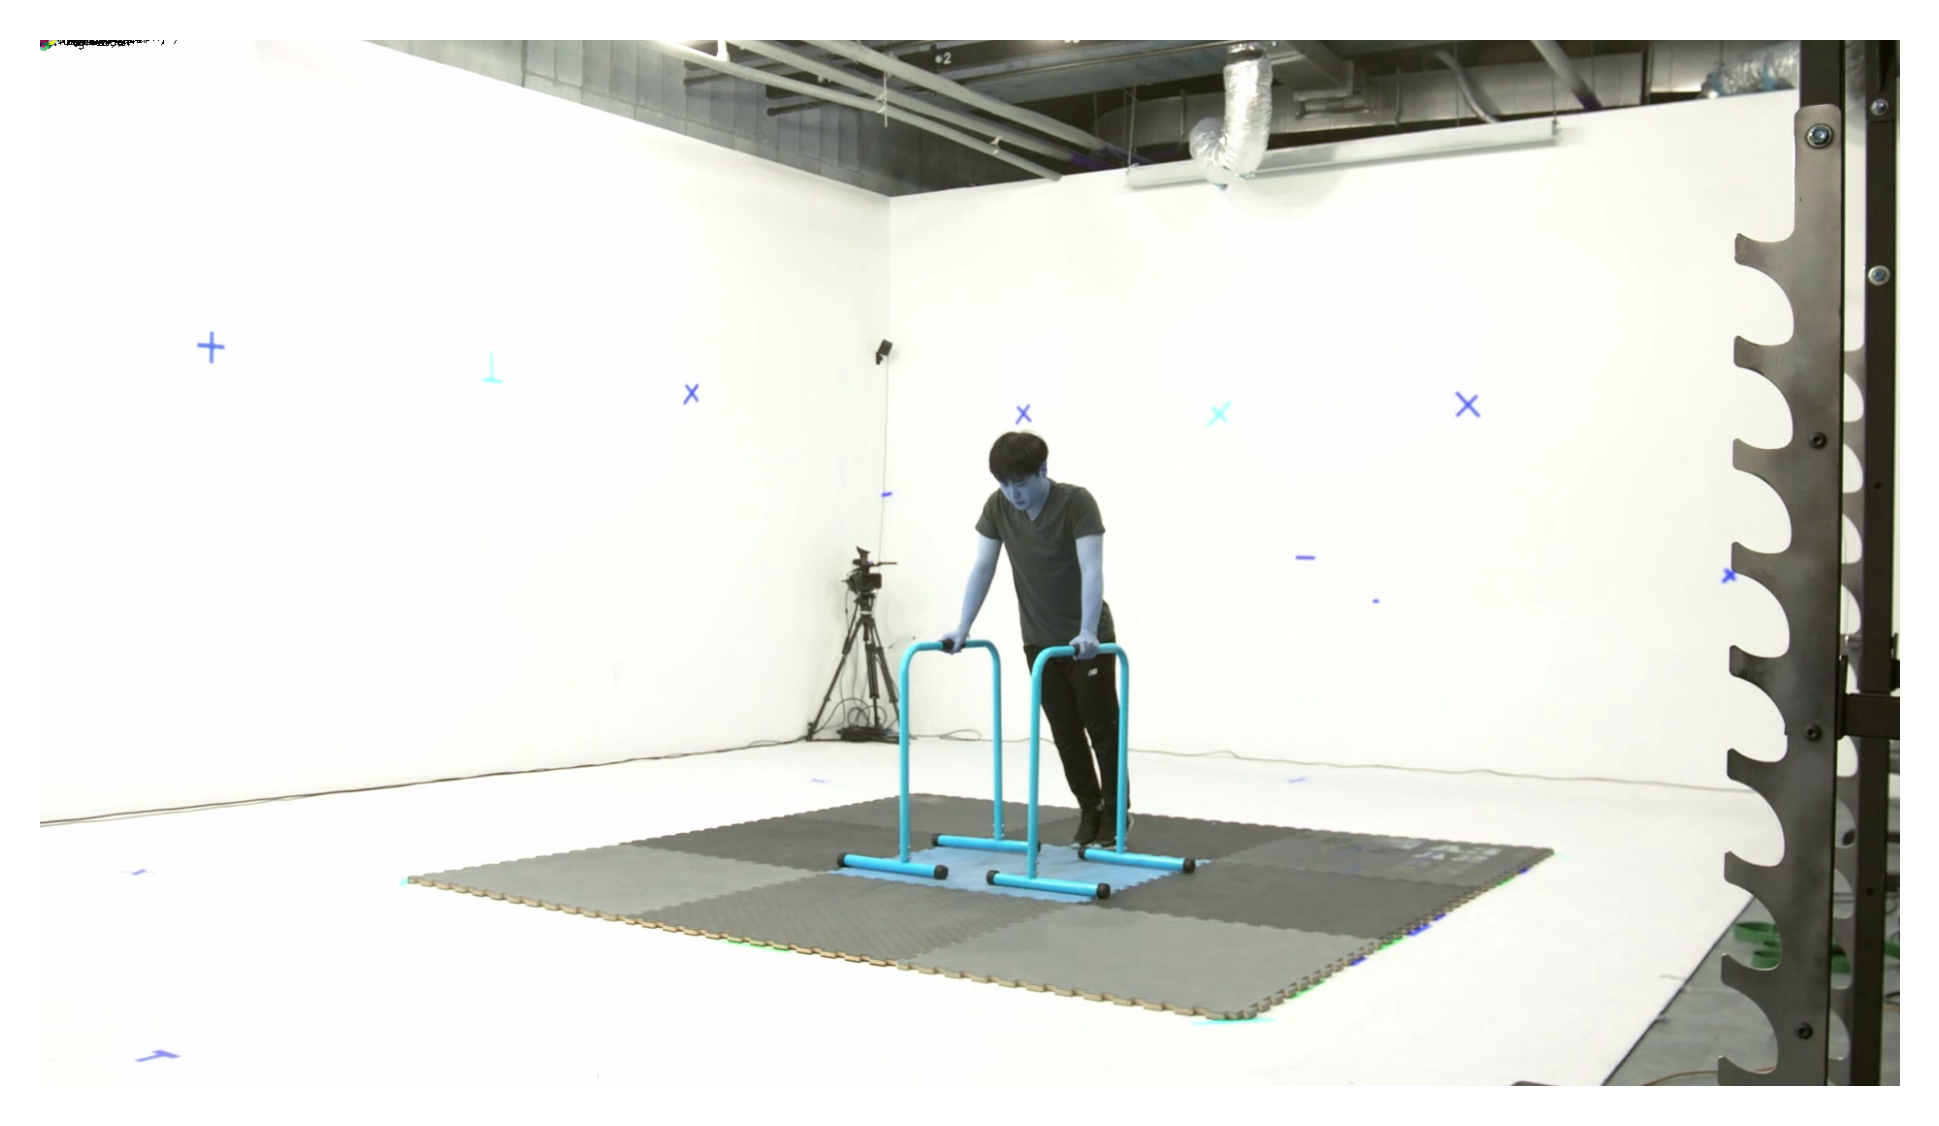

In [21]:
keypoints = aa.loc['697-3-5-34-Z94_D-0000001.jpg'].values.reshape(-1, 2)
keypoints = keypoints.astype(np.int64)
keypoint_names = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear', 
    4: 'right_ear', 
    5: 'left_shoulder', 
    6: 'right_shoulder',
    7: 'left_elbow', 
    8: 'right_elbow',
    9: 'left_wrist', 
    10: 'right_wrist',
    11: 'left_hip', 
    12: 'right_hip',
    13: 'left_knee', 
    14: 'right_knee',
    15: 'left_ankle', 
    16: 'right_ankle',
    17: 'neck', 
    18: 'left_palm', 
    19: 'right_palm', 
    20: 'spine2(back)',
    21: 'spine1(waist)', 
    22: 'left_instep',
    23: 'right_instep'
}

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (9, 18),
    (10, 19), (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
    (14, 16), (15, 22), (16, 23), (20, 21), (5, 6), (5, 11),
    (6, 12), (11, 12), (17, 20), (20, 21), 
]

image = cv2.imread('E:/data/test_imgs/697-3-5-34-Z94_D-0000001.jpg', cv2.COLOR_BGR2RGB)
draw_keypoints(image, keypoints, edges, keypoint_names, boxes=False, dpi=400)

In [20]:
from typing import Tuple, List, Sequence, Callable, Dict
import numpy as np

def draw_keypoints(
    image: np.ndarray,
    keypoints: np.ndarray,
    edges: List[Tuple[int, int]] = None,
    keypoint_names: Dict[int, str] = None, 
    boxes: bool = True,
    dpi: int = 200
) -> None:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))): 
    """
    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}

    if boxes:
        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(
            image, 
            tuple(keypoint), 
            3, colors.get(i), thickness=3, lineType=cv2.FILLED)

        if keypoint_names is not None:
            cv2.putText(
                image, 
                f'{i}: {keypoint_names[i]}', 
                tuple(keypoint), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    if edges is not None:
        for i, edge in enumerate(edges):
            cv2.line(
                image, 
                tuple(keypoints[edge[0]]), 
                tuple(keypoints[edge[1]]),
                colors.get(edge[0]), 3, lineType=cv2.LINE_AA)

    fig, ax = plt.subplots(dpi=dpi)
    ax.imshow(image)
    ax.axis('off')
    plt.show()
    fig.savefig('example.png')